In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
os.environ["SHALLOWWATER_USE_NUMBA"] = "1"
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          wind_gyre_forcing,run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# tiny arrays just to trigger compilation
USE_NUMBA = os.getenv("SHALLOWWATER_USE_NUMBA", "1") == "1"
if USE_NUMBA:
    import numpy as np
    from shallowwater.operators import avg_u_to_center, avg_v_to_center
    u = np.zeros((8, 9)); v = np.zeros((9, 8))
    _ = avg_u_to_center(u); _ = avg_v_to_center(v)
else:
    print('not using numba')

In [3]:
import math

def save_every_for_target_frames(tmax, dt, n_frames, include_initial=True):
    """
    Choose a save_every stride to produce about n_frames snapshots over [0, tmax].
    """
    if n_frames <= 1:
        # only initial (or final) frame
        return max(1, math.ceil(tmax/dt))  # save at start; plot just one frame
    N = math.ceil(tmax / dt)
    intervals = (n_frames - 1) if include_initial else n_frames
    return max(1, int(round(N / intervals)))


### Linear case

In [20]:
# Grid & params
Nx, Ny = 128, 128
Lx, Ly = 2.0e6, 2.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

params = ModelParams(
    H=1000.0, g=9.81, rho=1025.0,
    f0=1e-4, beta=2e-11, y0=Ly/2,
    r=1/(12*86400),    # a bit more damping than linear case
    linear=True,       # <— enable nonlinear terms
    Ah=1000.0,          # (optional) lateral viscosity if needed
)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 10 * 86400.0
save_every = save_every_for_target_frames(tmax, dt, n_frames=120)

ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")
forcing_fn = lambda t, g, p: wind_gyre_forcing(t, g, p, tau0=0.1)
 
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"),
                show_progress=True,
                progress_kwargs={"desc": "Linear wind gyre", "unit": "step"}
               )

print('Saved steps:', len(out['time']))


Linear wind gyre: 100%|█████████████████████████████████████████████████████████| 10954/10954 [00:10<00:00, 1018.48step/s]

Saved steps: 121


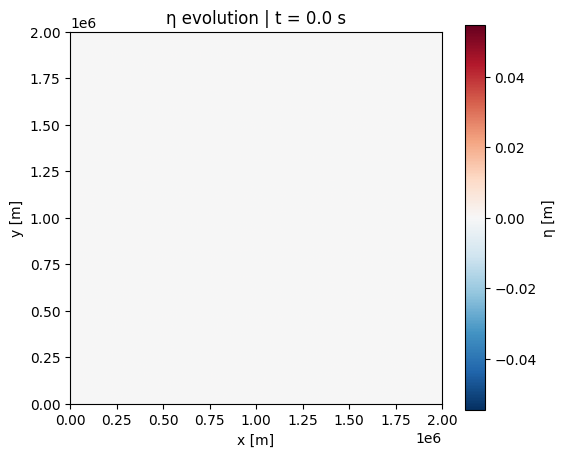

In [21]:
# Quick look animation (if you added visualize.py earlier)
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=120, title="η evolution")

# GIF (no external dependencies)
anim.save("eta_01.gif", fps=10)

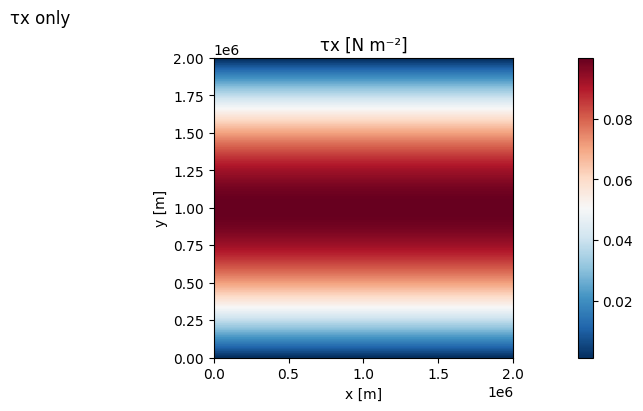

In [22]:
from shallowwater.visualize import plot_forcings

fig_tx = plot_forcings(forcing_fn, t=0.0, grid=grid, params=params, what="taux",
                       title="τx only")

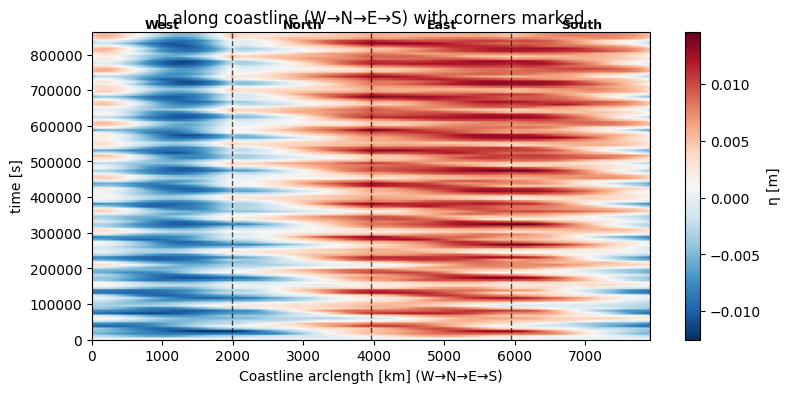

In [23]:
from shallowwater.visualize import coast_hovmoller

fig = coast_hovmoller(out, grid, units_x="km",
                      title="η along coastline (W→N→E→S) with corners marked")

### nonlinear case (momentum advection + lateral viscosity)

In [18]:
import importlib, shallowwater
importlib.reload(shallowwater)
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          wind_gyre_forcing, run_model, compute_dt_cfl)

def save_every_for_target_frames(tmax, dt, n_frames, include_initial=True):
    """
    Choose a save_every stride to produce about n_frames snapshots over [0, tmax].
    """
    import math
    if n_frames <= 1:
        # only initial (or final) frame
        return max(1, math.ceil(tmax/dt))  # save at start; plot just one frame
    N = math.ceil(tmax / dt)
    intervals = (n_frames - 1) if include_initial else n_frames
    return max(1, int(round(N / intervals)))

# Grid & params
Nx, Ny = 128, 128
Lx, Ly = 2.0e6, 2.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

params = ModelParams(
    H=1000.0, g=9.81, rho=1025.0,
    f0=1e-4, beta=2e-11, y0=Ly/2,
    r=1/(12*86400),
    linear=False,
    Ah=2000.0,
    Hmin_frac=0.02,
    qmax=5e-4,
)

# Use a stricter but reasonable wave CFL for nonlinear runs
dt = compute_dt_cfl(grid, params, cfl=0.25)
tmax = 10*86400.0
save_every = save_every_for_target_frames(tmax, dt, n_frames=120)

ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")

def wind_gyre_forcing_ramped(t, g, p, tau0=0.1, tramp=3*86400):
    s = 1.0 if t >= tramp else (t / float(tramp))
    taux_u, tauy_v, Q = wind_gyre_forcing(t, g, p, tau0=tau0)
    return s*taux_u, s*tauy_v, s*Q

forcing_fn = lambda t, g, p: wind_gyre_forcing_ramped(t, g, p, tau0=0.1, tramp=3*86400)

In [ ]:
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"),
                show_progress=True,
                progress_kwargs={"desc": "Nonlinear wind gyre", "unit": "step"}
               )

print('Saved steps:', len(out['time']))

Nonlinear wind gyre:  60%|█████████████████████████████████                      | 13167/21908 [00:21<00:13, 647.16step/s]

In [ ]:
it = len(out['time'])
time = out['time'][it]
eta0, u0, v0 = out['eta'][it], out['u'][it], out['v'][it]
state0 = {"eta": eta0, "u": u0, "v": v0}
from shallowwater.dynamics import tendencies

deta_dt, du_dt, dv_dt = tendencies(state0, time, grid, params, forcing_fn)
print("eta max/min:", deta_dt.max(), deta_dt.min())
print("u max/min:", du_dt.max(), du_dt.min())
print("v max/min:", dv_dt.max(), dv_dt.min())

from shallowwater.operators import (avg_u_to_center, avg_v_to_center,
                                    avg_center_to_u, avg_center_to_v,
                                    grad_x_on_u, grad_y_on_v,
                                    divergence, curl_on_center)

# sanity: no huge values
for name, arr in [
    ("avg_u_to_center", avg_u_to_center(u0)),
    ("avg_v_to_center", avg_v_to_center(v0)),
    ("avg_center_to_u", avg_center_to_u(eta0)),
    ("avg_center_to_v", avg_center_to_v(eta0)),
    ("grad_x_on_u", grad_x_on_u(eta0, 1.0)),
    ("grad_y_on_v", grad_y_on_v(eta0, 1.0)),
    ("curl_on_center", curl_on_center(u0, v0, 1.0, 1.0)),
    ("divergence", divergence(u0, v0, 1.0, 1.0)),
]:
    print(name, "max abs:", float(np.max(np.abs(arr))))


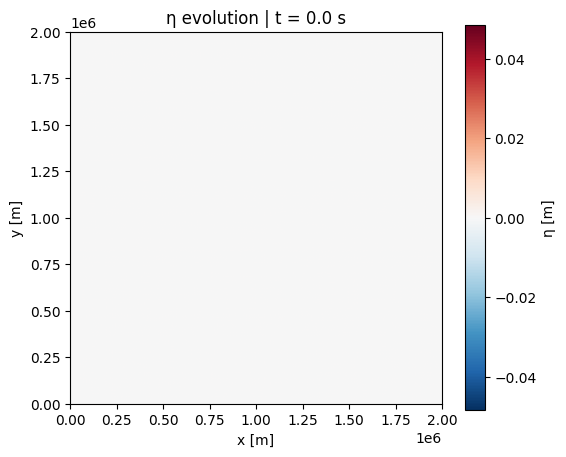

In [10]:
# Quick look animation (if you added visualize.py earlier)
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=120, title="η evolution")

# GIF (no external dependencies)
anim.save("eta_01b_nonlinear.gif", fps=10)